In [50]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold #Кросс-валидация
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import csv

### Обработка данных

In [51]:
d1 = []
d2 = []
with open('sqli.csv', newline='') as File:
    reader = csv.reader(File)
    for row in reader:
        d1.append(row[0])
        try:
            if row[1] != '1':
                d2.append('NaN')
            else:
                d2.append(int(row[1]))
        except:
            d2.append('NaN')
        

d1.pop(0)
d2.pop(0)

d1 = pd.Series(d1)
d2 = pd.Series(d2)
data = pd.concat([d1, d2],axis=1)
data.columns = ['Sentence', 'Label']

data[data[:1129] == 'NaN'] = 1
data[data[1129:] == 'NaN' ] = 0

y = data['Label']
X = data['Sentence']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Метод SVM

In [3]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)   
y_train = y_train.astype('int')
X_test = vectorizer.transform(X_test)
y_test = y_test.astype('int')

#Cетка параметров для перебора 10^-5 ... 10^5 
grid = {'C': np.power(10.0, np.arange(-5, 6))}

#Кросс-валидация по 5 блокам
cv = KFold(n_splits=5, shuffle=True, random_state=0)

#Обучение и подбор параметра С
clf = SVC(kernel='linear', random_state=0)
gs = GridSearchCV(clf, grid, scoring='accuracy', cv=cv) #Подбор параметров (В нашем случае C)
gs.fit(X_train,y_train)
gs.cv_results_



{'mean_fit_time': array([0.20748458, 0.20598288, 0.21112237, 0.26992912, 0.21622615,
        0.20073495, 0.20952444, 0.23333988, 0.23476534, 0.23621368,
        0.23388333]),
 'std_fit_time': array([0.00778423, 0.00317871, 0.00625273, 0.007296  , 0.01003582,
        0.00840402, 0.01322081, 0.02326757, 0.02177363, 0.02154116,
        0.02679164]),
 'mean_score_time': array([0.04777074, 0.04265099, 0.04482846, 0.05894752, 0.04672832,
        0.04126124, 0.04053988, 0.04822807, 0.04842052, 0.04445724,
        0.04514432]),
 'std_score_time': array([0.00541676, 0.0057727 , 0.00704418, 0.00188661, 0.00180653,
        0.0016913 , 0.00570495, 0.00561366, 0.00705755, 0.00664922,
        0.00814952]),
 'param_C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                    1000.0, 10000.0, 100000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object)

In [52]:
#ВЫВОД Параметр С=10 дает лучший результат на 5 выборках

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)   
y_train = y_train.astype('int')
X_test = vectorizer.transform(X_test)
y_test = y_test.astype('int')

clf = SVC(kernel='linear', random_state=0, C=10) #С=1.0 по умолчанию
clf.fit(X_train,y_train)
print(X_train)

#10 слов с наибольшим абсолютным значением веса
#Находим слова с наиболее большим весом из get_feature_names()
df = pd.DataFrame(np.transpose(abs(clf.coef_.toarray())), #Берем по модулю потому что 2 класса todense() переводит матрицу из разряженной в обычную 
                   index=np.asarray(vectorizer.get_feature_names()), 
                   columns=["col"])


  (1, 736)	0.5595668488286685
  (1, 3283)	0.5021060376389519
  (1, 3444)	0.6593743008780867
  (2, 114)	0.22408114742580754
  (2, 1232)	0.20550087147090867
  (2, 3152)	0.1610509535839669
  (2, 3181)	0.22408114742580754
  (2, 3283)	0.16235880672046896
  (2, 3461)	0.178384229259323
  (2, 4001)	0.1809390826753678
  (2, 4666)	0.19049999422553257
  (2, 4911)	0.14586834227314394
  (2, 4959)	0.15980395330442418
  (2, 5154)	0.12995181225497202
  (2, 5554)	0.22408114742580754
  (2, 5556)	0.22408114742580754
  (2, 6076)	0.22408114742580754
  (2, 6150)	0.20550087147090867
  (2, 6151)	0.18376334209757508
  (2, 6497)	0.3106519126165559
  (2, 7121)	0.19049999422553257
  (2, 7616)	0.20550087147090867
  (2, 7689)	0.12728806631824513
  (2, 8007)	0.17390623226317678
  (2, 8163)	0.22408114742580754
  :	:
  (3139, 2392)	0.37651147653323536
  (3139, 3940)	0.29220527045640865
  (3139, 4143)	0.31407260370043555
  (3139, 5769)	0.32702984051959305
  (3139, 5929)	0.27135415818791964
  (3139, 6412)	0.158863815826

### Вывод опорных слов (векторов)

In [53]:
df_sort = df.sort_values(by='col')[::-1]
display(df_sort[:30].sort_index())

,col
0x730065006c0065006300740020004000400076006500,1.587318
10000000,2.613383
21,1.587507
26,1.587365
28,1.587330
29,1.587337
7c,1.587304
asc,1.587462
bfilename,1.587296
desc,1.587307


In [54]:
df1 = pd.DataFrame(np.transpose(clf.coef_.toarray()), #Берем по модулю потому что 2 класса todense() переводит матрицу из разряженной в обычную 
                   index=np.asarray(vectorizer.get_feature_names()), 
                   columns=["col"])
d = df1.sort_values(by='col')
display(d.iloc[-30:-1])
display(d.iloc[0:20])

,col
bfilename,1.587296
7c,1.587304
sp_password,1.587306
desc,1.587307
handler,1.587314
ues,1.587317
distinct,1.587317
0x730065006c0065006300740020004000400076006500,1.587318
objectclass,1.587318
to_timestamp_tz,1.587327


,col
quot,-1.346091
apos,-1.305127
the,-1.174359
fyodor,-1.155974
father,-0.895984
one,-0.894646
close,-0.886583
impunity,-0.852102
silencing,-0.852102
fell,-0.775527


### Вывод и предсказание
    Accuracy (доля верно угаданных) — sklearn.metrics.accuracy_score
    
    Precision (точность) — sklearn.metrics.precision_score
    
    Recall (полнота) — sklearn.metrics.recall_score
    
    F-мера — sklearn.metrics.f1_score

In [59]:
print(clf.score(X_test, y_test)) #оценка 0.97

print('Доля верно угаданных: ',accuracy_score(y_test, clf.predict(X_test))) 
print('F-мера: ', f1_score(y_test, clf.predict(X_test))) 
print('Точность: ', precision_score(y_test, clf.predict(X_test)))
print('Полнота: ',recall_score(y_test, clf.predict(X_test)))

X_test2 = ["SELECT `name`, `status`, `books` FROM `members` WHERE name = 'Demo' AND password ='111'",
           "SELECT * FROM members WHERE username = 'admin'--' AND password = 'password'", 
           "/*! MYSQL Special SQL */ (M): SELECT /*!32302 1/0, */ 1 FROM tablename",
           "if ((select user) = 'sa' OR (select user) = 'dbo') select 1 else select 1/0 (S)", 
           "SELECT LOAD_FILE(0x633A5C626F6F742E696E69)", 
           "CONCAT(str1, str2, str3, …) (M): SELECT CONCAT(login, password) FROM members",
           "SELECT (CHaR(75)||CHaR(76)||CHaR(77)) (P)",
           "SELECT header, txt FROM news UNION ALL SELECT name, pass FROM members",
           "') or ('1'='1--", 
           "GROUP BY table.columnfromerror1, columnfromerror2, columnfromerror3 HAVING 1=1 –", 
           "ORDER BY 3—", 
           "11223344) UNION SELECT NULL,NULL,NULL,NULL WHERE 1=2 –-", 
           "INSERT INTO members(id, user, pass) VALUES(1, ''+SUBSTRING(@@version,1,10) ,10)", 
           'INSERT tbl EXEC master..xp_cmdshell OSQL /Q"DBCC SHOWCONTIG"']

X_test2 = vectorizer.transform(X_test2)
print(clf.predict(X_test2))

X_test3 = ['Let me introduce myself. My name is Mariya I am a 20-year-old student from Donetsk.',
           'To advertise means to make information public.', 
           'But nowadays advertising doesn’t limit itself by a word ‘publicity’.',
           'Modern advertising has a task to show a product in a positive and pleasant way.',
           'It has an aim to make us want to buy it. But how and when did advertising appear?', 
           'In the United States companies have worked with advertisers since 1930.', 
           'They invented packaging that had to attract customers.',
           'They also created an idea of product placement.',
           'It means that a product is shown in the movies.', 
           'After that it gets well-known and well-sold.', 
           'For example, it was made with the luxury cars which were shown in James Bond films.',
           'Nowadays the new territory of commercials is Internet with social networks.', 
           'Small software called cookies allows offering ads according to the tastes of Internet users.', 
           'Certainly, in the near future the commercial advertising will be personalized for each of us.']

X_test3 = vectorizer.transform(X_test3)
print(clf.predict(X_test3))

0.9704198473282443
Доля верно угаданных:  0.9704198473282443
F-мера:  0.9460869565217391
Точность:  0.9963369963369964
Полнота:  0.9006622516556292
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0]


Confusion matrix, without normalization
[[745   1]
 [ 30 272]]


NameError: name 'itertools' is not defined

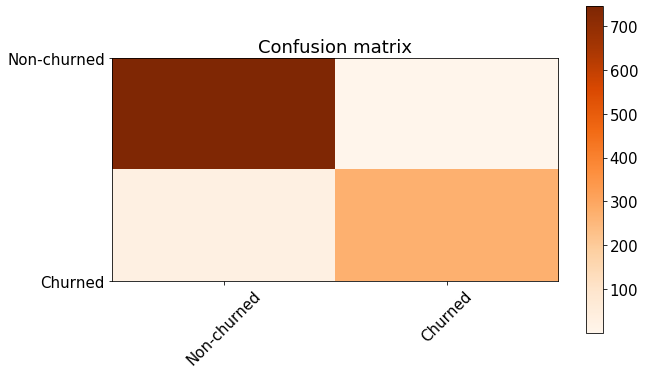

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'])
plt.savefig("conf_matrix.png")
plt.show()